In [1]:
import tensorflow as tf

# IMPORTANTE: Dejad este conjunto de lineas #
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
#############################################

Num GPUs Available:  2


In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

In [3]:
datapath = "data/pvpcdata.csv"
day = 24

In [4]:
df = pd.read_csv(datapath, sep = ";")

In [5]:
#Due to the hour format is between 0 to 23, we need to transform it
for i in df.index:
        df.at[i, 'hour'] = df.at[i, 'hour'] - 1

In [6]:
#To keep only valid valued, not the unusual ones
df = df.loc[df['hour'] < 24]

In [7]:
cols = ["year","month","day"]
df['date'] = df[cols].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")

In [8]:
df.head()

,year,month,day,hour,price,date
0,2017,1,1,0,58.82,2017-1-1
1,2017,1,1,1,58.23,2017-1-1
2,2017,1,1,2,51.95,2017-1-1
3,2017,1,1,3,47.27,2017-1-1
4,2017,1,1,4,46.90,2017-1-1


In [9]:
df['date'] = pd.to_datetime(df['date'].astype(str) + ' ' + df['hour'].astype(str) + ":00:00")

In [10]:
df = df.loc[df.date >= '2021-01-01 00:00:00']

[Text(0.5, 1.0, 'Energy prices per hour at the last day')]

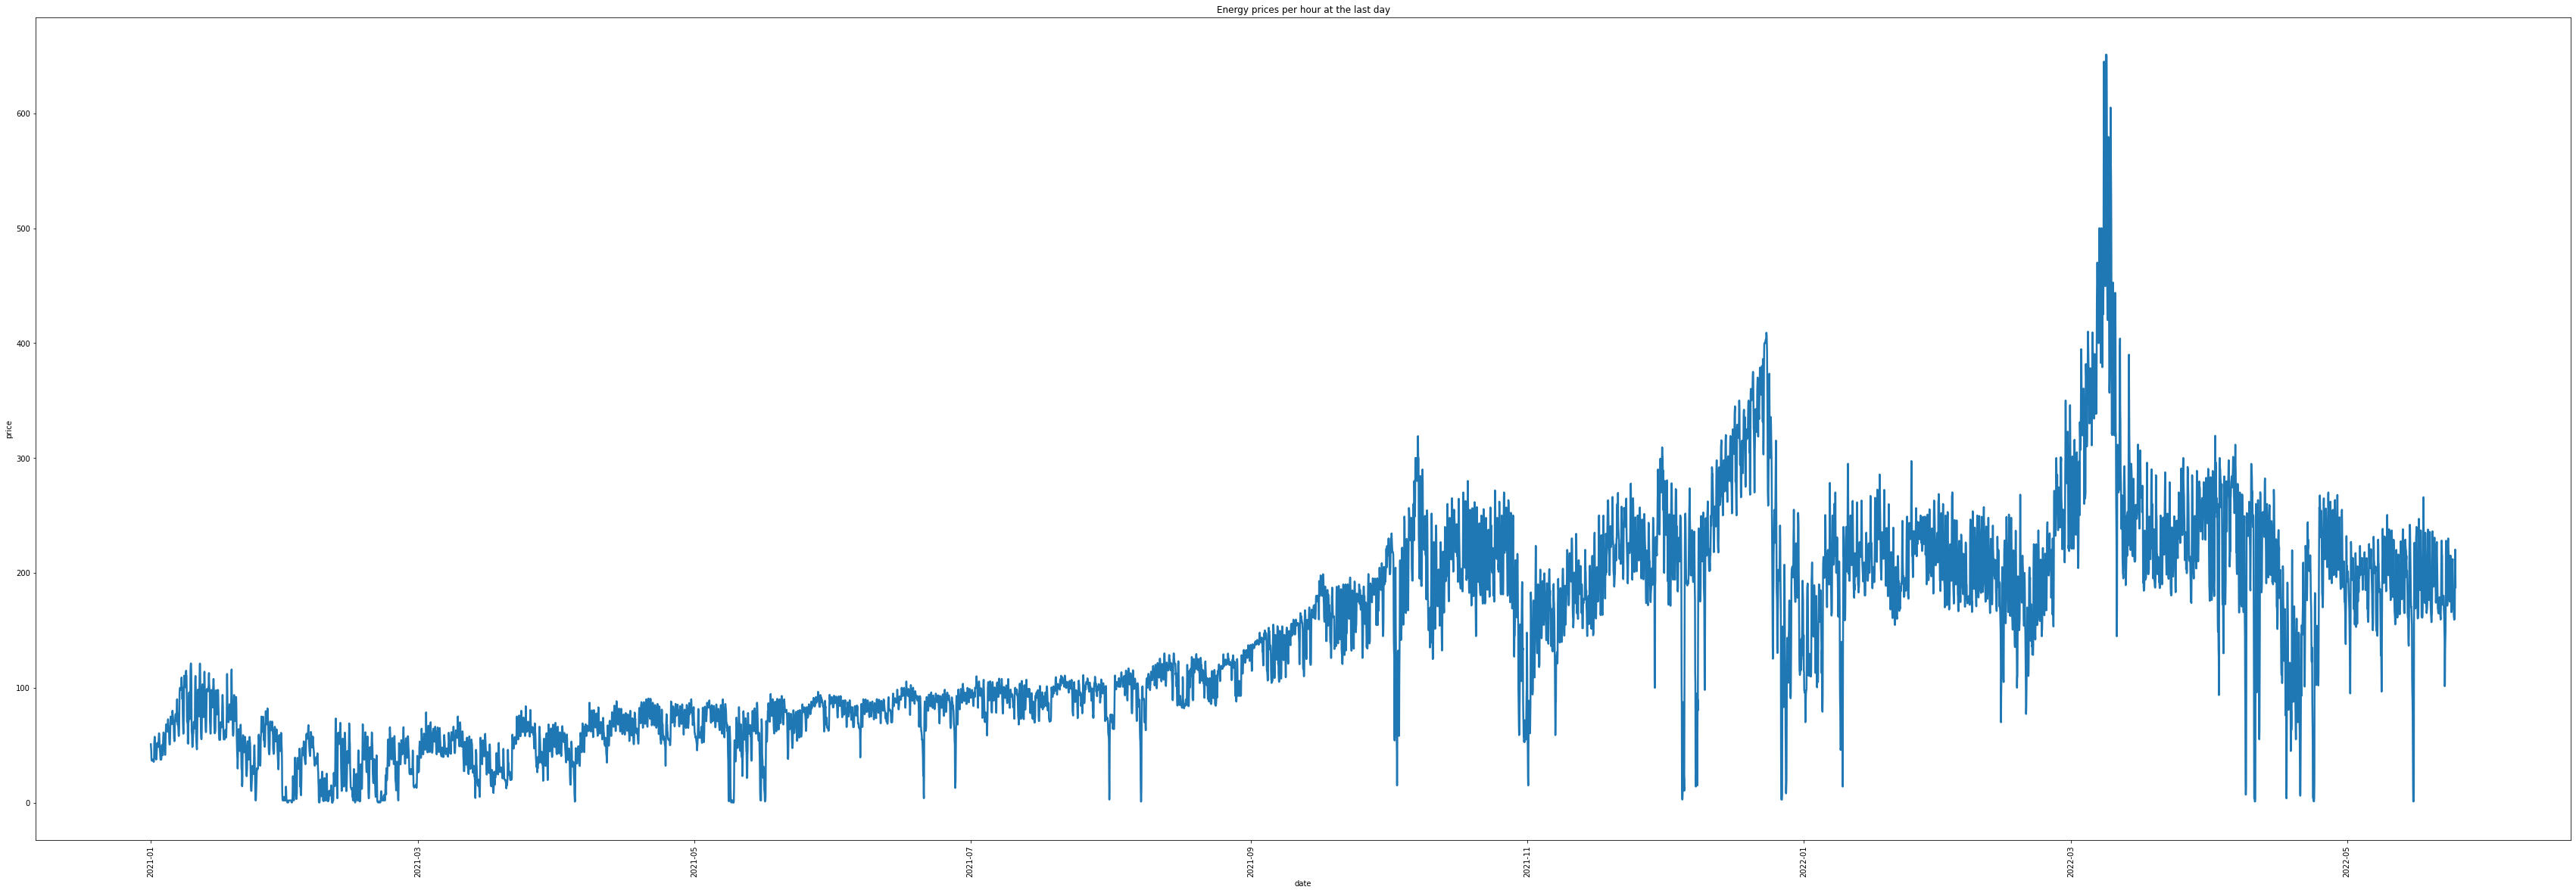

In [11]:
fig, ax = plt.subplots(figsize=(60,20))
plt.xticks(rotation=90)
sns.lineplot(x = 'date', y = 'price', data = df, linewidth = 2.5, ax = ax).set(title='Energy prices per hour at the last day')

In [12]:
df = df[['date', 'price']]

In [13]:
date = df.pop('date')

In [14]:
timestamp = date.map(datetime.datetime.timestamp)

In [15]:
sec_day = 24*60*60
sec_week = 7 * day
sec_year = 365.2425 * day

df['day_sin'] = np.sin(timestamp * (2*np.pi / sec_day))
df['day_cos'] = np.cos(timestamp * (2*np.pi / sec_day))
df['week_sin'] = np.sin(timestamp * (2*np.pi / sec_week))
df['week_cos'] = np.cos(timestamp * (2*np.pi / sec_week))
df['year_sin'] = np.sin(timestamp * (2*np.pi / sec_year))
df['year_cos'] = np.cos(timestamp * (2*np.pi / sec_year))

#Tamaño de ventana de 3 semanas, para calcular 1 semana
w_size = 24 * 7 * 3
#Número de entradas
n_inputs = len(df.columns)
n_outputs = 24 * 7

In [16]:
# Método de la ventana, parámetro único en X
# Aquí podemos ver como dadas 5 horas, predice la siguiente
# [[P1, DS1, DC1, YS1, YC1],[P2...],[P3...],[P4...],[P5...] --> [P6]
# [P2,P3,P4,P5,P6] --> [P7]

def df_to_x_y_multiple_input_output(df, w_size, n_outputs):
    df_as_np = df.to_numpy()
    x = []
    y = []
    
    #Bucle para construir la ventana varia. Incrementa según el número de salidas
    for i in range(0, len(df_as_np) - w_size - n_outputs, n_outputs):
        row = [r for r in df_as_np[i:(i + w_size)]]
        x.append(row)
        
        #Solo queremos el precio
        label = []
        for j in range((i + w_size), (i + w_size + n_outputs)):
            label.append(df_as_np[j][0])
        
        y.append(label)
    
    return np.array(x), np.array(y)

In [17]:
x, y = df_to_x_y_multiple_input_output(df, w_size, n_outputs)
x.shape, y.shape

((69, 504, 7), (69, 168))

In [18]:
x_train, x_aux, y_train, y_aux = train_test_split(x, y, test_size = 0.3, shuffle=False)
x_test, x_val, y_test, y_val = train_test_split(x_aux, y_aux, test_size = 0.33, shuffle=False)

In [19]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_val.shape, y_val.shape

((48, 504, 7), (48, 168), (14, 504, 7), (14, 168), (7, 504, 7), (7, 168))

In [20]:
x_mean = np.mean(x[:, :, 0])
x_std = np.std(x[:, :, 0])
print(x_mean)
print(x_std)

140.32118616287096
87.95638581328915


In [21]:
def standarize_input(df):
    df[:, :, 0] = (df[:, :, 0] - x_mean) / x_std
    return df

def standarize_output(df):
    df[:,:] = (df[:,:] - x_mean) / x_std
    return df

In [22]:
x_train_norm = standarize_input(x_train)
x_test_norm = standarize_input(x_test)
x_val_norm = standarize_input(x_val)
y_train_norm = standarize_output(y_train)
y_test_norm = standarize_output(y_test)
y_val_norm = standarize_output(y_val)

In [23]:
def build_model_lstm():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer((w_size, n_inputs)))
    model.add(tf.keras.layers.LSTM(128))
    model.add(tf.keras.layers.Dense(64, 'relu'))
    model.add(tf.keras.layers.Dense(n_outputs, 'linear'))
    model.compile(
        loss = 'mean_squared_error',
        optimizer = tf.keras.optimizers.Adam(0.001),
        metrics = ['mae', 'mse']
    )
    return model

In [24]:
def build_model_lstm_ret_seq():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer((w_size, n_inputs)))
    model.add(tf.keras.layers.LSTM(138, return_sequences = True))
    model.add(tf.keras.layers.LSTM(64))
    model.add(tf.keras.layers.Dense(32, 'relu'))
    model.add(tf.keras.layers.Dense(n_outputs, 'linear'))
    model.compile(
        loss = 'mean_squared_error',
        optimizer = tf.keras.optimizers.Adam(0.001),
        metrics = ['mae', 'mse']
    )
    return model

In [25]:
def build_model_cnn():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer((w_size, n_inputs)))
    model.add(tf.keras.layers.Conv1D(64, kernel_size = 2))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(32, 'relu'))
    model.add(tf.keras.layers.Dense(n_outputs, 'linear'))
    model.compile(
        loss = 'mean_squared_error',
        optimizer = tf.keras.optimizers.Adam(0.001),
        metrics = ['mae', 'mse']
    )
    return model

In [26]:
def build_model_cnn_relu():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer((w_size, n_inputs)))
    model.add(tf.keras.layers.Conv1D(64, kernel_size = 2, activation = 'relu'))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(32, 'relu'))
    model.add(tf.keras.layers.Dense(n_outputs, 'linear'))
    model.compile(
        loss = 'mean_squared_error',
        optimizer = tf.keras.optimizers.Adam(0.001),
        metrics = ['mae', 'mse']
    )
    return model

In [27]:
def build_model_gru():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer((w_size, n_inputs)))
    model.add(tf.keras.layers.GRU(64))
    model.add(tf.keras.layers.Dense(8, 'relu'))
    model.add(tf.keras.layers.Dense(n_outputs, 'linear'))
    model.compile(
        loss = 'mean_squared_error',
        optimizer = tf.keras.optimizers.Adam(0.001),
        metrics = ['mae', 'mse']
    )
    return model

In [28]:
def build_model_gru_ret_seq():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer((w_size, n_inputs)))
    model.add(tf.keras.layers.GRU(64, return_sequences = True))
    model.add(tf.keras.layers.GRU(32))
    model.add(tf.keras.layers.Dense(8, 'relu'))
    model.add(tf.keras.layers.Dense(n_outputs, 'linear'))
    model.compile(
        loss = 'mean_squared_error',
        optimizer = tf.keras.optimizers.Adam(0.001),
        metrics = ['mae', 'mse']
    )
    return model

In [29]:
def build_model_lstm_unrestricted():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer((w_size, n_inputs)))
    model.add(tf.keras.layers.LSTM(64, return_sequences = True))
    model.add(tf.keras.layers.LSTM(32, return_sequences = True))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(n_outputs, 'linear'))
    model.compile(
        loss = 'mean_squared_error',
        optimizer = tf.keras.optimizers.Adam(0.001),
        metrics = ['mae', 'mse']
    )
    return model

In [30]:
def build_model_lstm_dropout():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer((w_size, n_inputs)))
    model.add(tf.keras.layers.LSTM(64, return_sequences = True, recurrent_dropout = 0.5))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.LSTM(32, return_sequences = True, recurrent_dropout = 0.5))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(n_outputs, 'linear'))
    model.compile(
        loss = 'mean_squared_error',
        optimizer = tf.keras.optimizers.Adam(0.001),
        metrics = ['mae', 'mse']
    )
    return model

In [31]:
def build_model_lstm_go_bwd():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer((w_size, n_inputs)))
    model.add(tf.keras.layers.LSTM(64, return_sequences = True, go_backwards = True))
    model.add(tf.keras.layers.LSTM(32, return_sequences = True))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(n_outputs, 'linear'))
    model.compile(
        loss = 'mean_squared_error',
        optimizer = tf.keras.optimizers.Adam(0.001),
        metrics = ['mae', 'mse']
    )
    return model

In [32]:
def build_model_lstm_bidirectional():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer((w_size, n_inputs)))
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences = True)))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences = True)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(n_outputs, 'linear'))
    model.compile(
        loss = 'mean_squared_error',
        optimizer = tf.keras.optimizers.Adam(0.001),
        metrics = ['mae', 'mse']
    )
    return model

In [33]:
model_lstm = build_model_lstm()
model_cnn = build_model_cnn()
model_gru = build_model_gru()
model_lstm_ret_seq = build_model_lstm_ret_seq()
model_cnn_relu = build_model_cnn_relu()
model_lstm_unrestricted = build_model_lstm_unrestricted()
model_lstm_dropout = build_model_lstm_dropout()
model_lstm_go_bwd = build_model_lstm_go_bwd()
model_lstm_bi = build_model_lstm_bidirectional()

2022-06-15 12:06:19.069493: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-15 12:06:20.083900: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 28927 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:5b:00.0, compute capability: 7.0
2022-06-15 12:06:20.085139: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 30039 MB memory:  -> device: 1, name: Tesla V100-PCIE-32GB, pci bus id: 0000:d7:00.0, compute capability: 7.0


In [34]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', mode='auto', restore_best_weights=True, patience=15)

In [35]:
history_lstm = model_lstm.fit(
    x_train_norm,
    y_train_norm,
    validation_data = (x_val_norm, y_val_norm),
    epochs = 500,
    verbose = 1,
    shuffle = False, 
    callbacks = callback
)

Epoch 1/500


2022-06-15 12:06:23.622103: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8100


2/2 [==============================] - 2s 422ms/step - loss: 0.8335 - mae: 0.7960 - mse: 0.8335 - val_loss: 0.7552 - val_mae: 0.7571 - val_mse: 0.7552
Epoch 2/500
2/2 [==============================] - 0s 92ms/step - loss: 0.8158 - mae: 0.7867 - mse: 0.8158 - val_loss: 0.7469 - val_mae: 0.7518 - val_mse: 0.7469
Epoch 3/500
2/2 [==============================] - 0s 92ms/step - loss: 0.8024 - mae: 0.7791 - mse: 0.8024 - val_loss: 0.7350 - val_mae: 0.7440 - val_mse: 0.7350
Epoch 4/500
2/2 [==============================] - 0s 92ms/step - loss: 0.7854 - mae: 0.7690 - mse: 0.7854 - val_loss: 0.7180 - val_mae: 0.7325 - val_mse: 0.7180
Epoch 5/500
2/2 [==============================] - 0s 94ms/step - loss: 0.7618 - mae: 0.7539 - mse: 0.7618 - val_loss: 0.6942 - val_mae: 0.7150 - val_mse: 0.6942
Epoch 6/500
2/2 [==============================] - 0s 91ms/step - loss: 0.7280 - mae: 0.7298 - mse: 0.7280 - val_loss: 0.6651 - val_mae: 0.6888 - val_mse: 0.6651
Epoch 7/500
2/2 [======================

In [36]:
history_cnn = model_cnn.fit(
    x_train_norm,
    y_train_norm,
    validation_data = (x_val_norm, y_val_norm),
    epochs = 500,
    verbose = 1,
    shuffle = False, 
    callbacks = callback
)

Epoch 1/500
2/2 [==============================] - 1s 164ms/step - loss: 1.5051 - mae: 0.9952 - mse: 1.5051 - val_loss: 1.3732 - val_mae: 0.9315 - val_mse: 1.3732
Epoch 2/500
2/2 [==============================] - 0s 44ms/step - loss: 1.9279 - mae: 1.0373 - mse: 1.9279 - val_loss: 1.2469 - val_mae: 0.9053 - val_mse: 1.2469
Epoch 3/500
2/2 [==============================] - 0s 55ms/step - loss: 0.8469 - mae: 0.7918 - mse: 0.8469 - val_loss: 0.7646 - val_mae: 0.7616 - val_mse: 0.7646
Epoch 4/500
2/2 [==============================] - 0s 47ms/step - loss: 0.8438 - mae: 0.7976 - mse: 0.8438 - val_loss: 0.7654 - val_mae: 0.7629 - val_mse: 0.7654
Epoch 5/500
2/2 [==============================] - 0s 43ms/step - loss: 0.8291 - mae: 0.7944 - mse: 0.8291 - val_loss: 0.7654 - val_mae: 0.7630 - val_mse: 0.7654
Epoch 6/500
2/2 [==============================] - 0s 46ms/step - loss: 0.8259 - mae: 0.7933 - mse: 0.8259 - val_loss: 0.7648 - val_mae: 0.7627 - val_mse: 0.7648
Epoch 7/500
2/2 [==========

In [37]:
history_cnn_relu = model_cnn_relu.fit(
    x_train_norm,
    y_train_norm,
    validation_data = (x_val_norm, y_val_norm),
    epochs = 500,
    verbose = 1,
    shuffle = False, 
    callbacks = callback
)

Epoch 1/500
2/2 [==============================] - 0s 134ms/step - loss: 1.3347 - mae: 0.9601 - mse: 1.3347 - val_loss: 0.7968 - val_mae: 0.7520 - val_mse: 0.7968
Epoch 2/500
2/2 [==============================] - 0s 47ms/step - loss: 0.9988 - mae: 0.7899 - mse: 0.9988 - val_loss: 0.7541 - val_mae: 0.7568 - val_mse: 0.7541
Epoch 3/500
2/2 [==============================] - 0s 45ms/step - loss: 0.8289 - mae: 0.7944 - mse: 0.8289 - val_loss: 0.7656 - val_mae: 0.7629 - val_mse: 0.7656
Epoch 4/500
2/2 [==============================] - 0s 50ms/step - loss: 0.8291 - mae: 0.7944 - mse: 0.8291 - val_loss: 0.7655 - val_mae: 0.7629 - val_mse: 0.7655
Epoch 5/500
2/2 [==============================] - 0s 48ms/step - loss: 0.8289 - mae: 0.7943 - mse: 0.8289 - val_loss: 0.7655 - val_mae: 0.7629 - val_mse: 0.7655
Epoch 6/500
2/2 [==============================] - 0s 53ms/step - loss: 0.8287 - mae: 0.7942 - mse: 0.8287 - val_loss: 0.7654 - val_mae: 0.7629 - val_mse: 0.7654
Epoch 7/500
2/2 [==========

In [38]:
history_gru = model_gru.fit(
    x_train_norm,
    y_train_norm,
    validation_data = (x_val_norm, y_val_norm),
    epochs = 500,
    verbose = 1,
    shuffle = False,
    callbacks = callback
)

Epoch 1/500
2/2 [==============================] - 2s 347ms/step - loss: 0.8296 - mae: 0.7938 - mse: 0.8296 - val_loss: 0.7701 - val_mae: 0.7645 - val_mse: 0.7701
Epoch 2/500
2/2 [==============================] - 0s 87ms/step - loss: 0.8253 - mae: 0.7912 - mse: 0.8253 - val_loss: 0.7687 - val_mae: 0.7641 - val_mse: 0.7687
Epoch 3/500
2/2 [==============================] - 0s 94ms/step - loss: 0.8221 - mae: 0.7893 - mse: 0.8221 - val_loss: 0.7677 - val_mae: 0.7639 - val_mse: 0.7677
Epoch 4/500
2/2 [==============================] - 0s 91ms/step - loss: 0.8189 - mae: 0.7873 - mse: 0.8189 - val_loss: 0.7670 - val_mae: 0.7637 - val_mse: 0.7670
Epoch 5/500
2/2 [==============================] - 0s 94ms/step - loss: 0.8156 - mae: 0.7851 - mse: 0.8156 - val_loss: 0.7666 - val_mae: 0.7636 - val_mse: 0.7666
Epoch 6/500
2/2 [==============================] - 0s 89ms/step - loss: 0.8120 - mae: 0.7826 - mse: 0.8120 - val_loss: 0.7663 - val_mae: 0.7634 - val_mse: 0.7663
Epoch 7/500
2/2 [==========

In [39]:
history_lstm_unrestricted = model_lstm_unrestricted.fit(
    x_train_norm,
    y_train_norm,
    validation_data = (x_val_norm, y_val_norm),
    epochs = 500,
    verbose = 1,
    shuffle = False,
    callbacks = callback
)

Epoch 1/500
2/2 [==============================] - 3s 649ms/step - loss: 0.7511 - mae: 0.7630 - mse: 0.7511 - val_loss: 0.8499 - val_mae: 0.6407 - val_mse: 0.8499
Epoch 2/500
2/2 [==============================] - 0s 124ms/step - loss: 0.3745 - mae: 0.5121 - mse: 0.3745 - val_loss: 1.0769 - val_mae: 0.7762 - val_mse: 1.0769
Epoch 3/500
2/2 [==============================] - 0s 134ms/step - loss: 0.1650 - mae: 0.2972 - mse: 0.1650 - val_loss: 0.6052 - val_mae: 0.5521 - val_mse: 0.6052
Epoch 4/500
2/2 [==============================] - 0s 125ms/step - loss: 0.1996 - mae: 0.3480 - mse: 0.1996 - val_loss: 0.4646 - val_mae: 0.4882 - val_mse: 0.4646
Epoch 5/500
2/2 [==============================] - 0s 127ms/step - loss: 0.2255 - mae: 0.3778 - mse: 0.2255 - val_loss: 0.4684 - val_mae: 0.4891 - val_mse: 0.4684
Epoch 6/500
2/2 [==============================] - 0s 130ms/step - loss: 0.1451 - mae: 0.2664 - mse: 0.1451 - val_loss: 0.5569 - val_mae: 0.5239 - val_mse: 0.5569
Epoch 7/500
2/2 [=====

In [40]:
history_lstm_dropout = model_lstm_dropout.fit(
    x_train_norm,
    y_train_norm,
    validation_data = (x_val_norm, y_val_norm),
    epochs = 500,
    verbose = 1,
    shuffle = False,
    callbacks = callback
)

Epoch 1/500
2/2 [==============================] - 7s 3s/step - loss: 0.8074 - mae: 0.7891 - mse: 0.8074 - val_loss: 0.5356 - val_mae: 0.5286 - val_mse: 0.5356
Epoch 2/500
2/2 [==============================] - 4s 2s/step - loss: 0.2938 - mae: 0.4524 - mse: 0.2938 - val_loss: 0.9637 - val_mae: 0.7046 - val_mse: 0.9637
Epoch 3/500
2/2 [==============================] - 4s 2s/step - loss: 0.1911 - mae: 0.3169 - mse: 0.1911 - val_loss: 0.9179 - val_mae: 0.7182 - val_mse: 0.9179
Epoch 4/500
2/2 [==============================] - 4s 2s/step - loss: 0.2291 - mae: 0.3710 - mse: 0.2291 - val_loss: 0.7515 - val_mae: 0.6358 - val_mse: 0.7515
Epoch 5/500
2/2 [==============================] - 4s 2s/step - loss: 0.2120 - mae: 0.3619 - mse: 0.2120 - val_loss: 0.6512 - val_mae: 0.5788 - val_mse: 0.6512
Epoch 6/500
2/2 [==============================] - 4s 2s/step - loss: 0.1497 - mae: 0.2738 - mse: 0.1497 - val_loss: 0.6045 - val_mae: 0.5524 - val_mse: 0.6045
Epoch 7/500
2/2 [=======================

In [41]:
history_lstm_go_bwd = model_lstm_go_bwd.fit(
    x_train_norm,
    y_train_norm,
    validation_data = (x_val_norm, y_val_norm),
    epochs = 500,
    verbose = 1,
    shuffle = False,
    callbacks = callback
)

Epoch 1/500
2/2 [==============================] - 2s 659ms/step - loss: 0.7629 - mae: 0.7732 - mse: 0.7629 - val_loss: 0.8900 - val_mae: 0.6653 - val_mse: 0.8900
Epoch 2/500
2/2 [==============================] - 0s 126ms/step - loss: 0.8456 - mae: 0.8118 - mse: 0.8456 - val_loss: 0.8062 - val_mae: 0.6440 - val_mse: 0.8062
Epoch 3/500
2/2 [==============================] - 0s 144ms/step - loss: 0.1388 - mae: 0.2574 - mse: 0.1388 - val_loss: 0.5763 - val_mae: 0.5418 - val_mse: 0.5763
Epoch 4/500
2/2 [==============================] - 0s 125ms/step - loss: 0.3129 - mae: 0.4740 - mse: 0.3129 - val_loss: 0.5071 - val_mae: 0.5106 - val_mse: 0.5071
Epoch 5/500
2/2 [==============================] - 0s 123ms/step - loss: 0.2891 - mae: 0.4486 - mse: 0.2891 - val_loss: 0.5145 - val_mae: 0.5098 - val_mse: 0.5145
Epoch 6/500
2/2 [==============================] - 0s 133ms/step - loss: 0.1471 - mae: 0.2738 - mse: 0.1471 - val_loss: 0.5908 - val_mae: 0.5391 - val_mse: 0.5908
Epoch 7/500
2/2 [=====

In [42]:
history_lstm_bi = model_lstm_bi.fit(
    x_train_norm,
    y_train_norm,
    validation_data = (x_val_norm, y_val_norm),
    epochs = 500,
    verbose = 1,
    shuffle = False,
    callbacks = callback
)

Epoch 1/500
2/2 [==============================] - 5s 1s/step - loss: 0.7499 - mae: 0.7606 - mse: 0.7499 - val_loss: 3.4776 - val_mae: 1.5343 - val_mse: 3.4776
Epoch 2/500
2/2 [==============================] - 0s 206ms/step - loss: 3.8302 - mae: 1.7217 - mse: 3.8302 - val_loss: 0.8072 - val_mae: 0.6741 - val_mse: 0.8072
Epoch 3/500
2/2 [==============================] - 0s 225ms/step - loss: 0.1674 - mae: 0.2754 - mse: 0.1674 - val_loss: 0.4424 - val_mae: 0.5157 - val_mse: 0.4424
Epoch 4/500
2/2 [==============================] - 0s 205ms/step - loss: 1.1581 - mae: 0.9549 - mse: 1.1581 - val_loss: 0.3910 - val_mae: 0.4890 - val_mse: 0.3910
Epoch 5/500
2/2 [==============================] - 0s 199ms/step - loss: 0.6430 - mae: 0.7006 - mse: 0.6430 - val_loss: 0.4664 - val_mae: 0.4733 - val_mse: 0.4664
Epoch 6/500
2/2 [==============================] - 0s 216ms/step - loss: 0.1468 - mae: 0.2581 - mse: 0.1468 - val_loss: 1.0161 - val_mae: 0.7278 - val_mse: 1.0161
Epoch 7/500
2/2 [========

In [43]:
def plot_history(history, y_min, y_loss, y_mae, y_mse):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    #Graphic of Loss
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Loss Function')
    plt.plot(hist['epoch'], hist['loss'], label='Loss Error')
    plt.plot(hist['epoch'], hist['val_loss'], label = 'Val Error')
    plt.ylim([y_min,y_loss])
    plt.legend()
    
    #Graphic of MAE
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mae'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'], label = 'Val Error')
    plt.ylim([y_min,y_mae])
    plt.legend()
    
    #Graphic of MSE
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mse'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'], label = 'Val Error')
    plt.ylim([y_min,y_mse])
    plt.legend()
    
    
    plt.show()

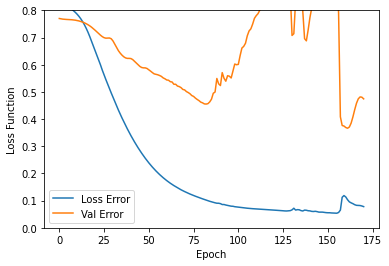

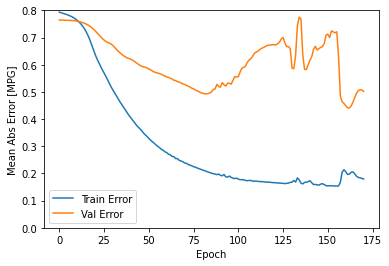

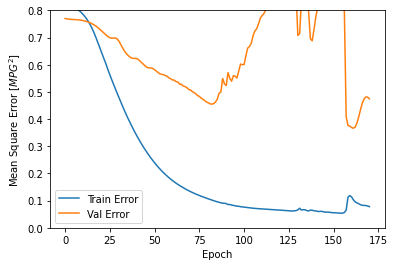

In [44]:
plot_history(history_gru, 0, 0.8, 0.8, 0.8)

In [45]:
def history_to_hist(history, string):
    hist = pd.DataFrame(history.history)
    temp = pd.to_numeric(hist[string], errors='coerce')
    res = []
    for i in range(temp.size):
        res.append(temp[i])
    return res

In [46]:
hist_lstm_loss = np.mean(history_to_hist(history_lstm, "loss"))
hist_cnn_loss = np.mean(history_to_hist(history_cnn, "loss"))
hist_gru_loss = np.mean(history_to_hist(history_gru, "loss"))
#hist_lstm_ret_seq_loss = np.mean(history_to_hist(history_lstm_ret_seq, "loss"))
hist_cnn_relu_loss = np.mean(history_to_hist(history_cnn_relu, "loss"))
hist_lstm_unrestricted_loss = np.mean(history_to_hist(history_lstm_unrestricted, "loss"))
hist_lstm_dropout_loss = np.mean(history_to_hist(history_lstm_dropout, "loss"))
hist_lstm_go_bwd_loss = np.mean(history_to_hist(history_lstm_go_bwd, "loss"))
hist_lstm_bi_loss = np.mean(history_to_hist(history_lstm_bi, "loss"))

In [47]:
hist_lstm_loss_val = np.mean(history_to_hist(history_lstm, "val_loss"))
hist_cnn_loss_val = np.mean(history_to_hist(history_cnn, "val_loss"))
hist_gru_loss_val = np.mean(history_to_hist(history_gru, "val_loss"))
#hist_lstm_ret_seq_loss_val = np.mean(history_to_hist(history_lstm_ret_seq, "val_loss"))
hist_cnn_relu_loss_val = np.mean(history_to_hist(history_cnn_relu, "val_loss"))
hist_lstm_unrestricted_loss_val = np.mean(history_to_hist(history_lstm_unrestricted, "val_loss"))
hist_lstm_dropout_loss_val = np.mean(history_to_hist(history_lstm_dropout, "val_loss"))
hist_lstm_go_bwd_loss_val = np.mean(history_to_hist(history_lstm_go_bwd, "val_loss"))
hist_lstm_bi_loss_val = np.mean(history_to_hist(history_lstm_bi, "val_loss"))

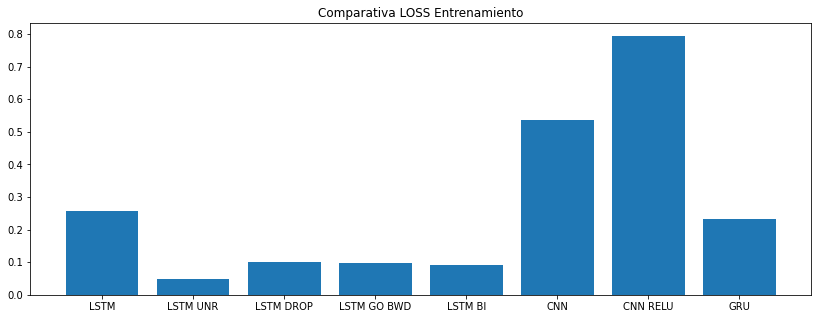

In [48]:
x_axis = ["LSTM", "LSTM UNR", "LSTM DROP", "LSTM GO BWD", "LSTM BI", "CNN", "CNN RELU", "GRU"]
y_axis = [hist_lstm_loss, hist_lstm_unrestricted_loss, hist_lstm_dropout_loss, hist_lstm_go_bwd_loss, hist_lstm_bi_loss, hist_cnn_loss, hist_cnn_relu_loss, hist_gru_loss]
plt.figure(figsize=(14,5))
plt.title("Comparativa LOSS Entrenamiento")
plt.bar(x_axis, y_axis)
plt.show()

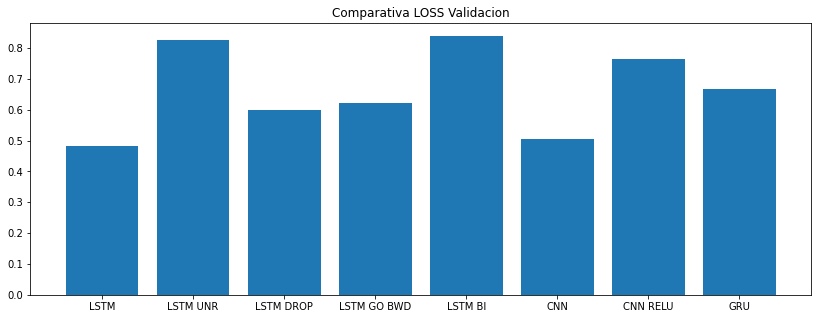

In [50]:
x_axis = ["LSTM", "LSTM UNR", "LSTM DROP", "LSTM GO BWD", "LSTM BI", "CNN", "CNN RELU", "GRU"]
y_axis = [hist_lstm_loss_val, hist_lstm_unrestricted_loss_val, hist_lstm_dropout_loss_val, hist_lstm_go_bwd_loss_val, hist_lstm_bi_loss_val, hist_cnn_loss_val, hist_cnn_relu_loss_val, hist_gru_loss_val]
plt.figure(figsize=(14,5))
plt.title("Comparativa LOSS Validacion")
plt.bar(x_axis, y_axis)
plt.show()

In [51]:
y_pred_lstm = model_lstm.predict(x_test_norm)
y_pred_cnn = model_cnn.predict(x_test_norm)
y_pred_gru = model_gru.predict(x_test_norm)
y_pred_lstm_ret_seq = model_lstm_ret_seq.predict(x_test_norm)
y_pred_cnn_relu = model_cnn_relu.predict(x_test_norm)
y_pred_lstm_unrestricted = model_lstm_unrestricted.predict(x_test_norm)
y_pred_lstm_dropout = model_lstm_dropout.predict(x_test_norm)
y_pred_lstm_go_bwd = model_lstm_go_bwd.predict(x_test_norm)
y_pred_lstm_bi = model_lstm_bi.predict(x_test_norm)

In [52]:
def inverse_standarize_input(arr):
    arr = (arr * x_std) + x_mean
    return arr

In [53]:
y_pred_lstm = inverse_standarize_input(y_pred_lstm)
y_pred_cnn = inverse_standarize_input(y_pred_cnn)
y_pred_gru = inverse_standarize_input(y_pred_gru)
y_pred_lstm_ret_seq = inverse_standarize_input(y_pred_lstm_ret_seq)
y_pred_cnn_relu = inverse_standarize_input(y_pred_cnn_relu)
y_test = inverse_standarize_input(y_test_norm)
y_pred_lstm_unrestricted = inverse_standarize_input(y_pred_lstm_unrestricted)
y_pred_lstm_bi = inverse_standarize_input(y_pred_lstm_bi)
y_pred_lstm_dropout = inverse_standarize_input(y_pred_lstm_dropout)
y_pred_lstm_go_bwd = inverse_standarize_input(y_pred_lstm_go_bwd)

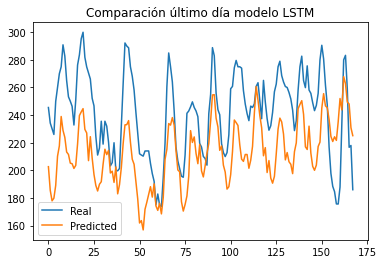

In [54]:
plt.plot(y_test[(y_test.shape[0] - 1)], label='Real')
plt.plot(y_pred_lstm[(y_test.shape[0] - 1)], label='Predicted')
plt.title("Comparación último día modelo LSTM")
plt.legend()

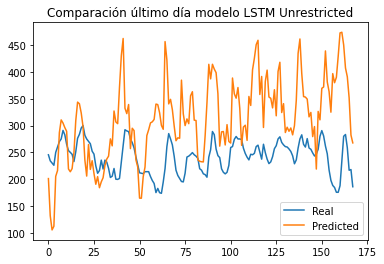

In [55]:
plt.plot(y_test[(y_test.shape[0] - 1)], label='Real')
plt.plot(y_pred_lstm_unrestricted[(y_test.shape[0] - 1)], label='Predicted')
plt.title("Comparación último día modelo LSTM Unrestricted")
plt.legend()

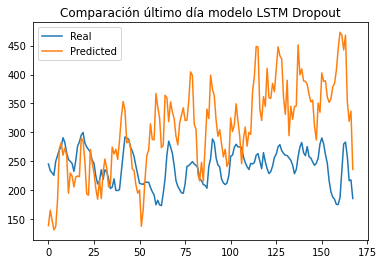

In [56]:
plt.plot(y_test[(y_test.shape[0] - 1)], label='Real')
plt.plot(y_pred_lstm_dropout[(y_test.shape[0] - 1)], label='Predicted')
plt.title("Comparación último día modelo LSTM Dropout")
plt.legend()

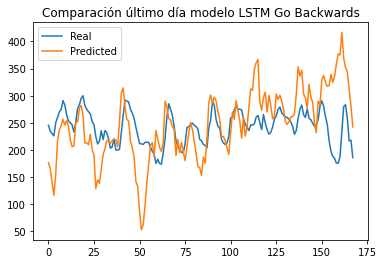

In [57]:
plt.plot(y_test[(y_test.shape[0] - 1)], label='Real')
plt.plot(y_pred_lstm_go_bwd[(y_test.shape[0] - 1)], label='Predicted')
plt.title("Comparación último día modelo LSTM Go Backwards")
plt.legend()

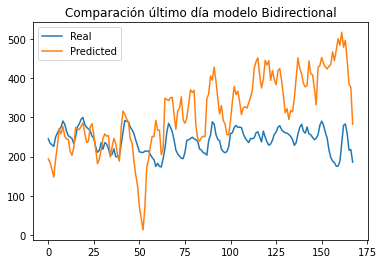

In [58]:
plt.plot(y_test[(y_test.shape[0] - 1)], label='Real')
plt.plot(y_pred_lstm_bi[(y_test.shape[0] - 1)], label='Predicted')
plt.title("Comparación último día modelo Bidirectional")
plt.legend()

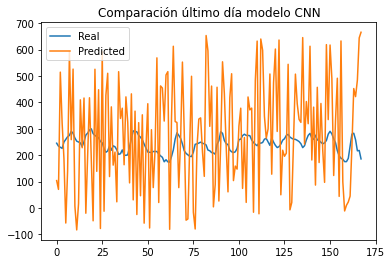

In [59]:
plt.plot(y_test[(y_test.shape[0] - 1)], label='Real')
plt.plot(y_pred_cnn[(y_test.shape[0] - 1)], label='Predicted')
plt.title("Comparación último día modelo CNN")
plt.legend()

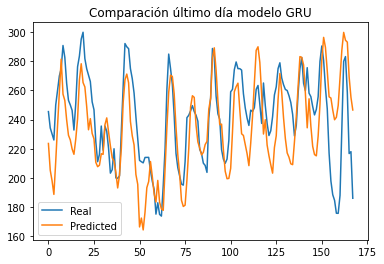

In [60]:
plt.plot(y_test[(y_test.shape[0] - 1)], label='Real')
plt.plot(y_pred_gru[(y_test.shape[0] - 1)], label='Predicted')
plt.title("Comparación último día modelo GRU")
plt.legend()

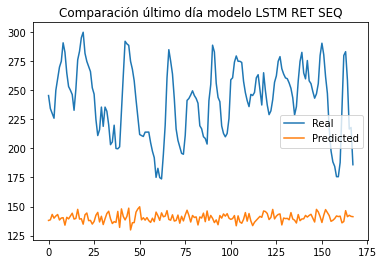

In [61]:
plt.plot(y_test[(y_test.shape[0] - 1)], label='Real')
plt.plot(y_pred_lstm_ret_seq[(y_test.shape[0] - 1)], label='Predicted')
plt.title("Comparación último día modelo LSTM RET SEQ")
plt.legend()

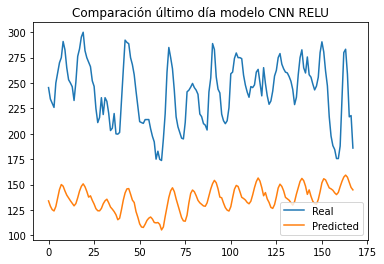

In [62]:
plt.plot(y_test[(y_test.shape[0] - 1)], label='Real')
plt.plot(y_pred_cnn_relu[(y_test.shape[0] - 1)], label='Predicted')
plt.title("Comparación último día modelo CNN RELU")
plt.legend()

In [63]:
rmse_lstm = np.sqrt(mean_squared_error(y_test, y_pred_lstm))
mae_lstm = mean_absolute_error(y_test, y_pred_lstm)
rmse_cnn = np.sqrt(mean_squared_error(y_test, y_pred_cnn))
mae_cnn = mean_absolute_error(y_test, y_pred_cnn)
rmse_gru = np.sqrt(mean_squared_error(y_test, y_pred_gru))
mae_gru = mean_absolute_error(y_test, y_pred_gru)
rmse_lstm_ret_seq = np.sqrt(mean_squared_error(y_test, y_pred_lstm_ret_seq))
mae_lstm_ret_seq = mean_absolute_error(y_test, y_pred_lstm_ret_seq)
rmse_cnn_relu = np.sqrt(mean_squared_error(y_test, y_pred_cnn_relu))
mae_cnn_relu = mean_absolute_error(y_test, y_pred_cnn_relu)
rmse_lstm_unrestricted = np.sqrt(mean_squared_error(y_test, y_pred_lstm_unrestricted))
mae_lstm_unrestricted = mean_absolute_error(y_test, y_pred_lstm_unrestricted)
rmse_lstm_dropout = np.sqrt(mean_squared_error(y_test, y_pred_lstm_dropout))
mae_lstm_dropout = mean_absolute_error(y_test, y_pred_lstm_dropout)
rmse_lstm_go_bwd = np.sqrt(mean_squared_error(y_test, y_pred_lstm_go_bwd))
mae_lstm_go_bwd = mean_absolute_error(y_test, y_pred_lstm_go_bwd)
rmse_lstm_bi = np.sqrt(mean_squared_error(y_test, y_pred_lstm_bi))
mae_lstm_bi = mean_absolute_error(y_test, y_pred_lstm_bi)

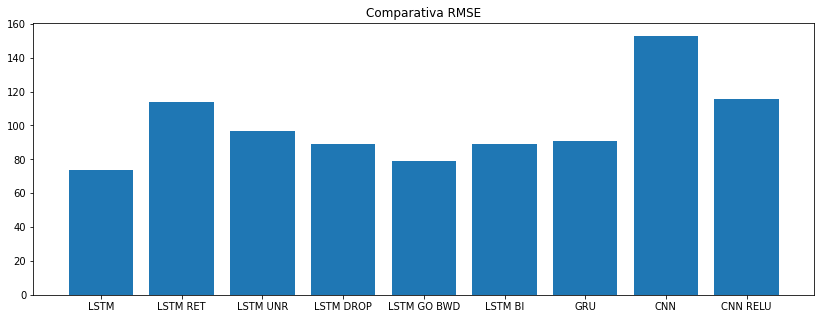

In [64]:
x_axis = ["LSTM", "LSTM RET", "LSTM UNR", "LSTM DROP", "LSTM GO BWD", "LSTM BI", "GRU", "CNN", "CNN RELU"]
y_axis = [rmse_lstm, rmse_lstm_ret_seq, rmse_lstm_unrestricted, rmse_lstm_dropout, rmse_lstm_go_bwd, rmse_lstm_bi, rmse_gru, rmse_cnn, rmse_cnn_relu]
plt.figure(figsize=(14,5))
plt.title("Comparativa RMSE")
plt.bar(x_axis, y_axis)
plt.show()

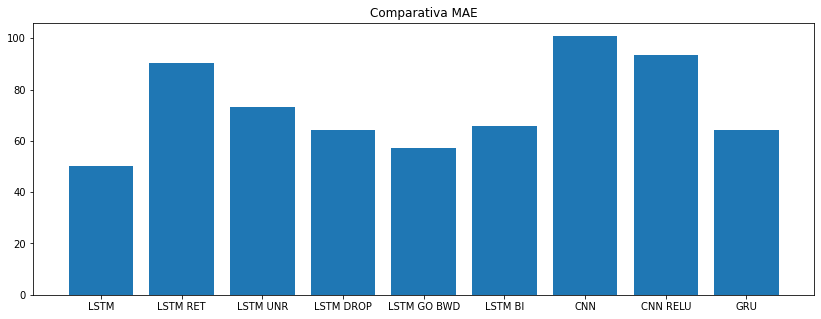

In [65]:
x_axis = ["LSTM", "LSTM RET", "LSTM UNR", "LSTM DROP", "LSTM GO BWD", "LSTM BI", "CNN", "CNN RELU", "GRU"]
y_axis = [mae_lstm, mae_lstm_ret_seq, mae_lstm_unrestricted, mae_lstm_dropout, mae_lstm_go_bwd, mae_lstm_bi, mae_cnn, mae_cnn_relu, mae_gru]
plt.figure(figsize=(14,5))
plt.title("Comparativa MAE")
plt.bar(x_axis, y_axis)
plt.show()

In [66]:
model_gru.save("modelweek")

2022-06-15 12:22:47.435431: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: modelweek/assets


INFO:tensorflow:Assets written to: modelweek/assets
